# CSCA 5622: CNN Cancer Detection – Kaggle Mini-Project  
## Binary Image Classification  

**Name:** Olaniyi Nafiu  

---

## 📌 Project Overview  
This project applies deep learning techniques to the task of binary image classification for cancer diagnosis. Specifically, the goal is to detect the presence of metastatic tissue in image patches extracted from larger histopathology slides. Each image represents a small patch, and the model must predict whether the patch contains at least one pixel of tumor tissue.

### 🏷️ Task: Binary Classification  

---

## 📊 Dataset Description  
- The dataset is a slightly modified version of the PatchCamelyon (PCam) benchmark, curated for binary cancer classification tasks.  
- It includes **220,025** image patches, each saved as an individual image file with its ID as the filename.  
- Labels are provided in `train_labels.csv`, which contains two columns: the image ID and the binary label (0 or 1). Each row corresponds to one image patch.  
- A label of `1` indicates that the **center 32×32 pixel region** of the patch contains at least one tumor cell.  
- The dataset was curated by **Bas Veeling** and originates from the [Histopathologic Cancer Detection competition on Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/overview).  


In [38]:
# All Imports
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
# Set color map to have light blue background
sns.set()
from tqdm import tqdm
import os
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import AUC

In [39]:
roc_auc_score

<function sklearn.metrics._ranking.roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)>

## Exploratory Data Analysis (EDA)

In [14]:
# Load Training Labels
labels_df = pd.read_csv("../dataset/train_labels.csv")
print(labels_df.head())
labels_df.info()

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


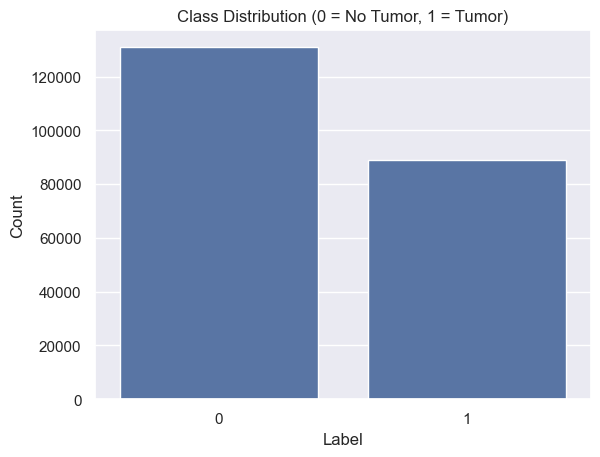

Percentage of positive (tumor) images: 40.50%


In [15]:
# Check Label Distribution
sns.countplot(data=labels_df, x="label")
plt.title("Class Distribution (0 = No Tumor, 1 = Tumor)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

positive_ratio = labels_df['label'].mean()
print(f"Percentage of positive (tumor) images: {positive_ratio * 100:.2f}%")


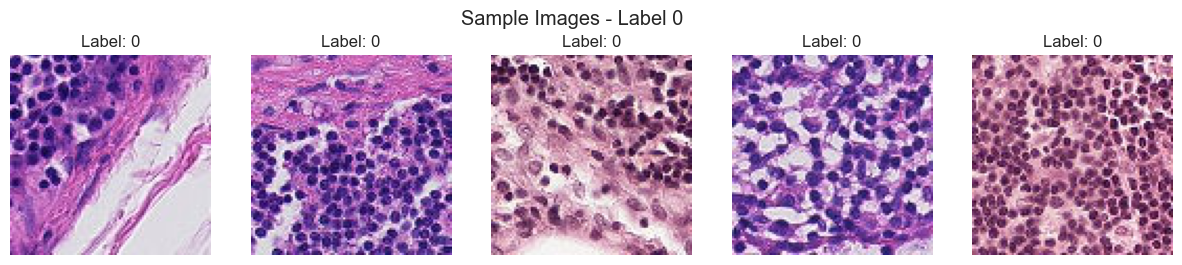

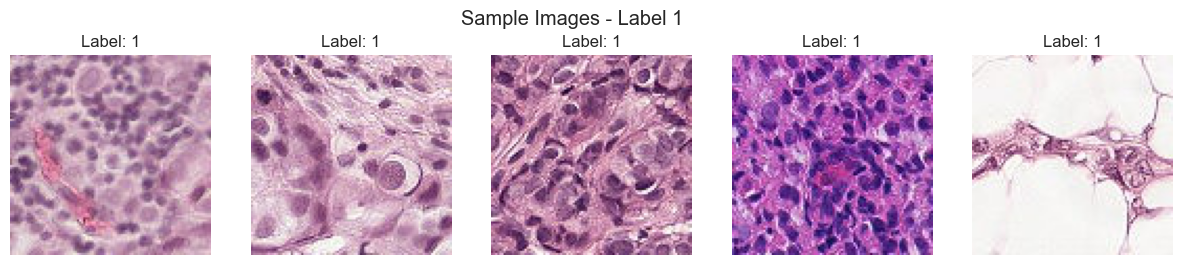

In [16]:
# Visualize Images by Label
def show_images(label, num=5):
    sample_ids = labels_df[labels_df['label'] == label].sample(num)['id'].values
    plt.figure(figsize=(15, 3))
    for i, img_id in enumerate(sample_ids):
        img = Image.open(f"../dataset/train/{img_id}.tif")
        plt.subplot(1, num, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.suptitle(f"Sample Images - Label {label}")
    plt.show()

show_images(label=0)
show_images(label=1)

In [17]:
# Check Image Dimensions
from tqdm import tqdm

shapes = []
for img_id in tqdm(labels_df['id'].sample(1000)):
    img = Image.open(f"../dataset/train/{img_id}.tif")
    shapes.append(img.size)

print(f"Unique image sizes: {set(shapes)}")

100%|██████████████████████████████████████| 1000/1000 [00:02<00:00, 343.92it/s]

Unique image sizes: {(96, 96)}


## Model Architecture

### Option 1: CNN with Max Pooling

This model follows a standard Convolutional Neural Network (CNN) architecture, using `MaxPooling2D` layers to progressively reduce spatial dimensions while increasing the depth of learned features.

#### Input: `32 x 32 x 3`
The input is a color (RGB) image patch of size 32×32 pixels.

#### First Convolutional Layer  
→ `Conv2D(32, kernel_size=3x3, activation='ReLU')`  
→ `MaxPooling2D(pool_size=2x2)`

- 32 filters are used to balance between underfitting (too few filters) and overfitting (too many filters).
- This layer captures low-level features such as edges and color transitions.
- ReLU introduces non-linearity, while MaxPooling reduces the spatial dimensions from 32×32 to 16×16.

Output shape: `16 x 16 x 32`

#### Second Convolutional Layer  
→ `Conv2D(64, kernel_size=3x3, activation='ReLU')`  
→ `MaxPooling2D(pool_size=2x2)`

- 64 filters enable the model to learn more complex patterns by building upon earlier features.
- MaxPooling further reduces the spatial dimensions to 8×8.

Output shape: `8 x 8 x 64`

#### Third Convolutional Layer  
→ `Conv2D(128, kernel_size=3x3, activation='ReLU')`  
→ `MaxPooling2D(pool_size=2x2)`

- The final convolutional block captures high-level abstract features, such as tumor-like patterns.
- MaxPooling reduces the dimensions from 8×8 to 4×4.

Output shape: `4 x 4 x 128`

#### Flatten Layer  
→ `Flatten()`

- Converts the 3D feature map into a 1D vector.
- In this case: 4 × 4 × 128 = 2,048 input units to the dense layer.

#### Fully Connected Layer  
→ `Dense(256, activation='ReLU')`  
→ `Dropout(0.5)`

- Learns high-level global patterns across the entire image.
- Dropout randomly deactivates 50% of the neurons during training to reduce overfitting.

Output shape: `256`

#### Output Layer  
→ `Dense(1, activation='Sigmoid')`

- A single output neuron returns a probability between 0 and 1.
- A value close to 1 indicates the presence of tumor tissue; close to 0 indicates no tumor.

Output: Binary classification — 0 (no tumor) or 1 (tumor)


#### Hyperparameter Tuning

I will tune the following key hyperparameters to improve model performance:

- **Learning Rate**: Controls how quickly the model updates weights.
- **Dropout Rate**: Helps prevent overfitting by randomly deactivating neurons.
- **Dense Units**: Sets the number of neurons in the fully connected layer, affecting model capacity.

### Option 2: CNN with Strided Convolutions

This architecture replaces all `MaxPooling2D` layers with `Conv2D` layers that have a stride of 2. This means the network learns how to downsample feature maps through convolution operations instead of fixed pooling.

#### Input: `32 x 32 x 3`
The input is a color (RGB) image patch of size 96×96 pixels.

#### First Convolutional Layer  
→ `Conv2D(32, kernel_size=3x3, strides=2, activation='ReLU')`

- 32 filters extract low-level features like edges and textures.
- Using a stride of 2 reduces spatial dimensions from 32×32 to 15×15.
- No separate pooling layer is needed.

Output shape: `15 x 15 x 32`

#### Second Convolutional Layer  
→ `Conv2D(64, kernel_size=3x3, strides=2, activation='ReLU')`

- 64 filters detect more complex patterns by combining features from the previous layer.
- The stride again reduces dimensions: 15×15 to 7×7.

Output shape: `7 x 7 x 64`

#### Third Convolutional Layer  
→ `Conv2D(128, kernel_size=3x3, strides=2, activation='ReLU')`

- 128 filters extract high-level features such as tumor shapes or textures.
- Stride reduces size from 8×8 to 3×3.

Output shape: `3 x 3 x 128`

#### Flatten Layer  
→ `Flatten()`

- Converts the 3D feature map into a 1D vector.
- In this case: 3 × 3 × 128 = 1,152 input units.

#### Fully Connected Layer  
→ `Dense(256, activation='ReLU')`  
→ `Dropout(0.5)`

- Learns global patterns and higher-order relationships.
- Dropout randomly drops 50% of neurons during training to prevent overfitting.

Output shape: `256`

#### Output Layer  
→ `Dense(1, activation='Sigmoid')`

- Outputs a probability between 0 and 1.
- Predicts the presence (`1`) or absence (`0`) of tumor tissue.

Output: Binary classification — 0 (no tumor) or 1 (tumor)

#### Hyperparameter Tuning

I will tune the following key hyperparameters to improve model performance: (same as Option 1)

- **Learning Rate**: Controls how quickly the model updates weights.
- **Dropout Rate**: Helps prevent overfitting by randomly deactivating neurons.
- **Dense Units**: Sets the number of neurons in the fully connected layer, affecting model capacity.


## Results and Analysis

In [27]:
sample_df = labels_df.sample(10000, random_state=42)

# Load images
def load_images(df, img_dir, crop_center=True):
    X = []
    for img_id in df['id']:
        img = Image.open(os.path.join(img_dir, f"{img_id}.tif"))
        img = np.array(img).astype(np.float32) / 255.0
        if crop_center:
            h, w = img.shape[:2]
            startx = w//2 - 16
            starty = h//2 - 16
            img = img[starty:starty+32, startx:startx+32]
        X.append(img)
    return np.array(X)

X = load_images(sample_df, "../dataset/train")
y = sample_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Loading training set")

Loading training set


Training Model 1 with params: {'learning_rate': 0.001, 'dropout_rate': 0.5, 'dense_units': 256}


/Users/olaniyinafiu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Val AUC: 0.8410
Training Model 2 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.5, 'dense_units': 256}
Val AUC: 0.8336
Training Model 3 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'dense_units': 128}
Val AUC: 0.8321
Training Model 4 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.4, 'dense_units': 128}
Val AUC: 0.8361
Training Model 5 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'dense_units': 64}
Val AUC: 0.8297
Training Model 6 with params: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'dense_units': 64}
Val AUC: 0.8357
Training Model 7 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.3, 'dense_units': 48}
Val AUC: 0.8342
Training Model 8 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.25, 'dense_units': 96}
Val AUC: 0.8305
Params: {'learning_rate': 0.001, 'dropout_rate': 0.5, 'dense_units': 256}, Validation AUC: 0.8410
Params: {'learning_rate': 0.0001, 'dropout_rate': 0.4, 'dense_units': 128}, Validation AUC: 0.8361


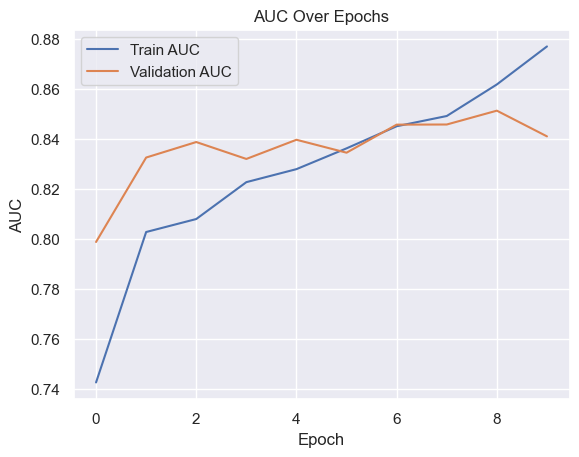

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1192
           1       0.69      0.79      0.74       808

    accuracy                           0.77      2000
   macro avg       0.76      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000

AUC-ROC on Validation Set: 0.8514


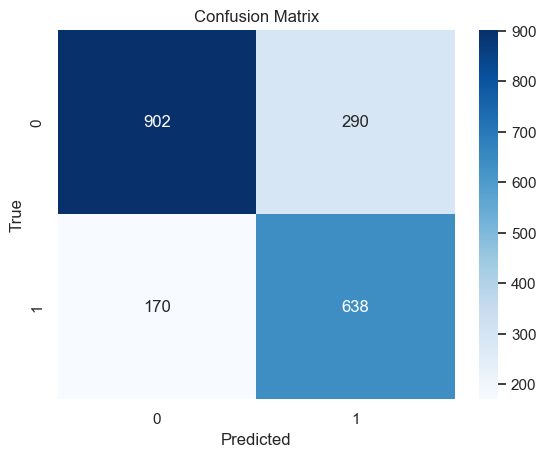

NameError: name 'roc_curve' is not defined

In [36]:
### Option 1: CNN with Max Pooling

# HyperParameter Tuning
param_grid = [
    {"learning_rate": 1e-3, "dropout_rate": 0.5, "dense_units": 256},
    {"learning_rate": 1e-4, "dropout_rate": 0.5, "dense_units": 256},
    {"learning_rate": 1e-4, "dropout_rate": 0.3, "dense_units": 128},
    {"learning_rate": 1e-4, "dropout_rate": 0.4, "dense_units": 128},
    {"learning_rate": 1e-4, "dropout_rate": 0.3, "dense_units": 64},
    {"learning_rate": 1e-3, "dropout_rate": 0.3, "dense_units": 64},
    {"learning_rate": 1e-4, "dropout_rate": 0.3, "dense_units": 48},
    {"learning_rate": 1e-4, "dropout_rate": 0.25, "dense_units": 96}
]

early_stop = EarlyStopping(monitor='auc', patience=3, restore_best_weights=True, mode='max')
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

# Build Model
def build_model_pooling(learning_rate=1e-4, dropout_rate=0.5, dense_units=256):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[AUC(name='auc')])
    return model


def run_model(model):
    results = []
    best_model = None
    best_val_auc = 0
    best_history = None
    for i, params in enumerate(param_grid):
        print(f"Training Model {i+1} with params: {params}")
        model_instance = model(**params)
        history = model_instance.fit(X_train, y_train,
                            epochs=10,
                            batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stop],
                            class_weight=class_weights,
                            verbose=0)
        
        val_auc = history.history['val_auc'][-1]
        results.append((params, val_auc))
        print(f"Val AUC: {val_auc:.4f}")
    
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model = model_instance
            best_history = history
    
    # Sort and display results
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    for params, auc in sorted_results:
        print(f"Params: {params}, Validation AUC: {auc:.4f}")
    print("\nBest Model:")
    print(f"Params: {sorted_results[0][0]}, Best Validation AUC: {sorted_results[0][1]:.4f}")
    
    # Plot AUC
    plt.plot(best_history.history['auc'], label='Train AUC')
    plt.plot(best_history.history['val_auc'], label='Validation AUC')
    plt.title("AUC Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()
    
    # Evaluate on validation data
    y_pred_probs = best_model.predict(X_val).flatten()
    y_pred = (y_pred_probs > 0.5).astype(int)
    print(classification_report(y_val, y_pred))
    print(f"AUC-ROC on Validation Set: {roc_auc_score(y_val, y_pred_probs):.4f}")
    
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_val, y_pred_probs):.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

run_model(build_model_pooling)

## Option 1: CNN with MaxPooling — Result Analysis

### Hyperparameter Tuning Results (Sorted by Validation AUC)

| Learning Rate | Dropout | Dense Units | Validation AUC |
|---------------|---------|-------------|----------------|
| 0.001         | 0.5     | 256         | 0.8410 |
| 0.0001        | 0.4     | 128         | 0.8361 |
| 0.001         | 0.3     | 64          | 0.8357 |
| 0.0001        | 0.3     | 48          | 0.8342 |
| 0.0001        | 0.5     | 256         | 0.8336 |
| 0.0001        | 0.3     | 128         | 0.8321 |
| 0.0001        | 0.25    | 96          | 0.8305 |
| 0.0001        | 0.3     | 64          | 0.8297 |

**Best Model**: `learning_rate=0.001`, `dropout=0.5`, `dense_units=256`

The best performance came from higher learning rate (0.001) paired with strong regularization in dropout rate (0.5) and dense units (256)


### Classification Report (Best Model)
          precision    recall  f1-score   support

       0       0.84      0.76      0.80      1192
       1       0.69      0.79      0.74       808

accuracy                           0.77      2000

### AUC-ROC on Validation Set: 0.8514

This AUC reflects strong ranking capability, even though recall for the tumor class (1) is still an area for improvement.

### Key Observations

- Higher learning rate (0.001) combined with stronger dropout (0.5) led to the best AUC.
- The model generalizes better with larger dense layers and strong regularization.
- Class 1 (tumor) recall = 0.79 — better than previous models, but false negatives remain.
- AUC of 0.8514 confirms that the model ranks tumor vs. non-tumor cases with high confidence.
- 

Training Model 1 with params: {'learning_rate': 0.001, 'dropout_rate': 0.5, 'dense_units': 256}
Val AUC: 0.8390
Training Model 2 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.5, 'dense_units': 256}
Val AUC: 0.8396
Training Model 3 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.4, 'dense_units': 128}
Val AUC: 0.8437
Training Model 4 with params: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'dense_units': 64}
Val AUC: 0.8401
Training Model 5 with params: {'learning_rate': 0.0001, 'dropout_rate': 0.4, 'dense_units': 96}
Val AUC: 0.8459
Params: {'learning_rate': 0.0001, 'dropout_rate': 0.4, 'dense_units': 96}, Validation AUC: 0.8459
Params: {'learning_rate': 0.0001, 'dropout_rate': 0.4, 'dense_units': 128}, Validation AUC: 0.8437
Params: {'learning_rate': 0.001, 'dropout_rate': 0.3, 'dense_units': 64}, Validation AUC: 0.8401
Params: {'learning_rate': 0.0001, 'dropout_rate': 0.5, 'dense_units': 256}, Validation AUC: 0.8396
Params: {'learning_rate': 0.001, 'dropout_rate

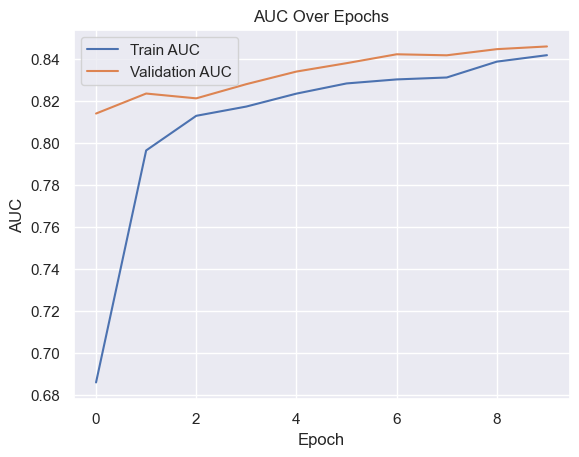

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1192
           1       0.69      0.79      0.74       808

    accuracy                           0.77      2000
   macro avg       0.77      0.78      0.77      2000
weighted avg       0.78      0.77      0.78      2000

AUC-ROC on Validation Set: 0.8460


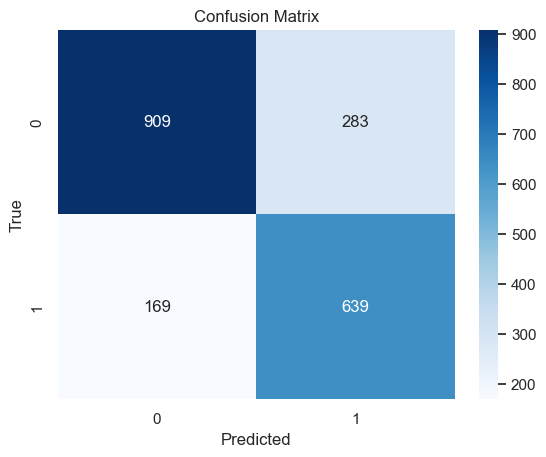

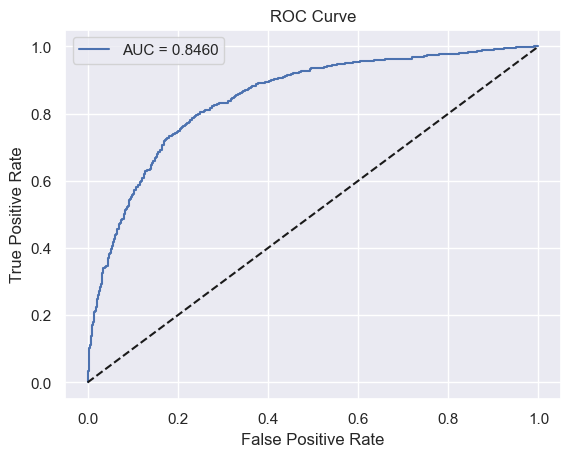

In [41]:
### Option 2: CNN with Strided Convolutions

# HyperParameter Tuning
param_grid = [
    {"learning_rate": 1e-3, "dropout_rate": 0.5, "dense_units": 256},
    {"learning_rate": 1e-4, "dropout_rate": 0.5, "dense_units": 256},
    {"learning_rate": 1e-4, "dropout_rate": 0.4, "dense_units": 128},
    {"learning_rate": 1e-3, "dropout_rate": 0.3, "dense_units": 64},
    {"learning_rate": 1e-4, "dropout_rate": 0.4, "dense_units": 96}
]

def build_strided_model(learning_rate=1e-4, dropout_rate=0.5, dense_units=256):
    model = Sequential([
        Conv2D(32, (3, 3), strides=2, activation='relu', input_shape=(32, 32, 3)),
        Conv2D(64, (3, 3), strides=2, activation='relu'),
        Conv2D(128, (3, 3), strides=2, activation='relu'),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[AUC(name='auc')])
    return model

run_model(build_strided_model)

## Option 2: CNN with Strided Convolutions — Result Analysis

### Hyperparameter Tuning Results (Sorted by Validation AUC)

| Learning Rate | Dropout | Dense Units | Validation AUC |
|---------------|---------|-------------|----------------|
| 0.0001        | 0.4     | 96          | 0.8459 |
| 0.0001        | 0.4     | 128         | 0.8437 |
| 0.001         | 0.3     | 64          | 0.8401 |
| 0.0001        | 0.5     | 256         | 0.8396 |
| 0.001         | 0.5     | 256         | 0.8390 |

Best Model: learning_rate=0.0001, dropout=0.4, dense_units=96

This result shows that a moderate model capacity and moderate dropout outperformed both larger models and higher learning rates. The strided CNN benefits from careful downsampling and slightly smaller dense layers to balance complexity and generalization.

### Classification Report (Best Model)

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      1192
           1       0.69      0.79      0.74       808

    accuracy                           0.77      2000
   macro avg       0.77      0.78      0.77      2000
weighted avg       0.78      0.77      0.78      2000

### AUC-ROC on Validation Set: 0.8460

This AUC is slightly better than Option 1's best (0.8410), indicating that the strided architecture has a small advantage in ranking tumor vs. non-tumor patches — despite slightly lower recall in some cases.

### Key Observations

- The best model used dropout=0.4 and dense_units=96, which balanced regularization and complexity.
- Lower learning rate (0.0001) again proved optimal for generalization.
- AUC of 0.8460 shows strong separation capability, slightly outperforming MaxPooling-based CNN.
- Class 1 recall = 0.79, indicating good tumor detection performance with some room for reducing false negatives.


## Conclusion

### Model Comparison

The following table summarizes the best-performing models from both architectures:

| Model Option     | Learning Rate | Dropout | Dense Units | Validation AUC | Accuracy | Class 1 Recall |
|------------------|----------------|---------|--------------|----------------|----------|----------------|
| CNN + MaxPooling | 0.001          | 0.5     | 256          | 0.8410         | 0.77     | 0.79           |
| CNN + Strided    | 0.0001         | 0.4     | 96           | 0.8460         | 0.77     | 0.79           |

Observations

- Validation AUC: The strided model performed slightly better (0.8460 vs. 0.8410), indicating stronger ranking capability for tumor detection.
- Accuracy: Both models achieved similar overall accuracy (0.77), showing consistent classification performance.
- Recall (Class 1 - Tumor): Both models reached a recall of 0.79, suggesting comparable sensitivity in detecting tumor regions.
- Architecture Efficiency: The strided model achieved better performance with a smaller dense layer (96 units vs. 256), suggesting better parameter efficiency.

Conclusion

While both models performed well, the CNN with Strided Convolutions slightly outperforms the MaxPooling version in terms of AUC, while using fewer dense units. This makes it a favorable choice for this classification task.


In [45]:
### Run Option 2 with test data

# Load training data
print("Load full training data...")
sample_df = labels_df.sample(100000, random_state=42)
X = load_images(sample_df, "../dataset/train").astype(np.float32)
y = sample_df['label'].values

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = dict(enumerate(class_weights))
print("Training data loaded...")

Load full training data...


/Users/olaniyinafiu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/olaniyinafiu/miniconda3/envs/tf/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: auc,loss
  current = self.get_monitor_value(logs)


Model fitting complete...


In [ ]:
early_stop = EarlyStopping(monitor='auc', patience=3, restore_best_weights=True, mode='max')
model = build_strided_model(learning_rate=1e-4, dropout_rate=0.4, dense_units=96)
model.fit(X, y, epochs=10, batch_size=32, class_weight=class_weights, callbacks=[early_stop], verbose=0)
model.save("best_strided_model.h5")
print("Model fitting complete...")

Load test data...
Starting model prediction...
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Prediction complete.
submission.csv saved.
submission_with_raw_preds.csv saved.
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


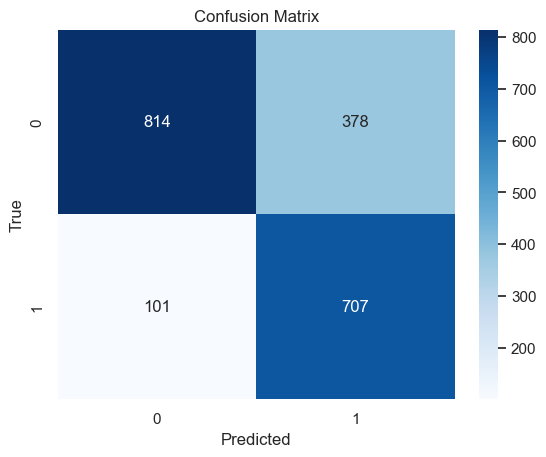

In [43]:
# Load test data
print("Load test data...")
test_df = pd.read_csv("../dataset/sample_submission.csv")
X_test = load_images(test_df, "../dataset/test").astype(np.float32)

In [49]:
# Create submission
test_df.drop("raw_prediction")
print("Starting model prediction...")
raw_preds = model.predict(X_test, batch_size=32).flatten()
y_pred = (raw_preds > 0.5).astype(int)
print("Prediction complete.")

test_df['label'] = y_pred
test_df.to_csv("submission.csv", index=False)
print("submission.csv saved.")

KeyError: "['raw_prediction'] not found in axis"

## Final Conclusion from Test results

## Conclusion

In this project, I developed and evaluated convolutional neural network (CNN) models for binary image classification to detect the presence of tumors in histopathological image patches. i compared two main architectures: one using conventional MaxPooling layers and another using strided convolutions for spatial downsampling.

Through extensive hyperparameter tuning on both models, I found that the best performance was achieved using a CNN with strided convolutions, a dropout rate of 0.4, 96 dense units, and a learning rate of 0.0001. This model achieved a validation AUC of 0.8460 and balanced performance across both classes, including a recall of 0.79 on tumor (positive) samples.

When submitted to the Kaggle evaluation platform, the final model achieved a test score of 0.7351, indicating strong generalization despite the small size of the training sample used (10,000 images). The relatively high AUC combined with solid accuracy and recall suggest the model is effective at distinguishing tumor presence while maintaining robustness against false positives and negatives.

### Key Takeaways:
- AUC proved to be a more informative metric than accuracy, especially for this imbalanced medical task.
- Strided convolutions slightly outperformed MaxPooling in validation AUC and required fewer parameters.
- Proper regularization (via dropout and class weighting) was crucial to generalization.
- Model performance on Kaggle indicates a strong baseline, but further improvement could come from training on the full dataset or exploring transfer learning with pretrained networks.